<a href="https://colab.research.google.com/github/Giffy/fast.ai/blob/master/Machine%20Learning/lesson3_randomforest_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# 1 Random Forest Model interpretation

## 1.0 Setup

### Google Colab setup
Installs fast.ai 0.7.0 and the required libraries to run the notebook.

Also downloads the required datasets.

In [1]:
print (" Installing FastAI libraries...")
!pip install fastai==0.7.0 > /dev/null
print ("\n Installing required libraries...")
!pip install feather > /dev/null
!pip install scikit-misc==0.1.0 > /dev/null
!pip install pdpbox==0.2.0 > /dev/null
!pip install treeinterpreter==0.2.2 > /dev/null
print ("\n Downloading train dataset...")
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
!tar xvf train.tar.gz > /dev/null
print ("\n Downloading dataframe processed ...")
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/df_raw.tar.gz
!tar xvf df_raw.tar.gz > /dev/null

 Installing FastAI libraries...
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.

 Installing required libraries...
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-install-ju8ufb3k/feather/

--2019-02-15 20:46:24--  https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9126495 (8.7M) [application/octet-stream]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   8.70M  --.-KB/s    in 0.08s  

### Import libraries 

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
set_plot_sizes(12,14,16)

##1.1 Load in our data from last lesson

In [0]:
PATH = "/content/data/bulldozers/"                        # changed data path

import feather                                            # Import feather library
df_raw=feather.read_dataframe('tmp/bulldozers-raw')       # replaced:  df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [9]:
df_raw.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# 2 Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [0]:
set_rf_samples(50000)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20573803035758872, 0.24982295033806814, 0.9115365277634918, 0.8885416422253563, 0.8945141108321216]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [0]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.42 s, sys: 41 ms, total: 1.46 s
Wall time: 1.46 s


(9.198610534465612, 0.239883293033631)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [0]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 94.7 ms, sys: 112 ms, total: 206 ms
Wall time: 1.6 s


(9.198610534465612, 0.239883293033631)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

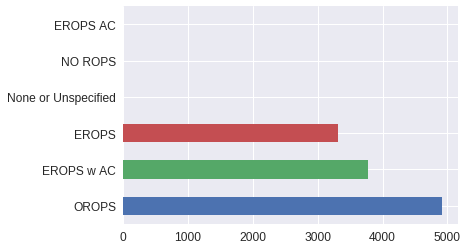

In [0]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [0]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838136,0.273627
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579309,0.267332
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683827,0.224615


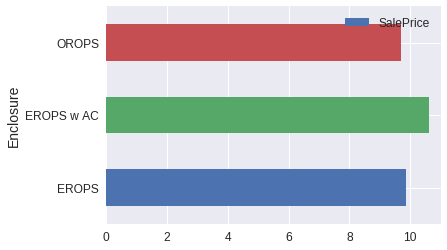

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

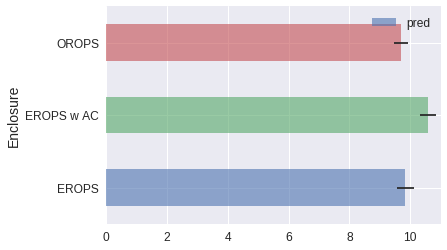

In [0]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

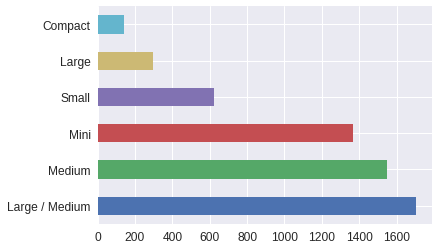

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();

In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.850149,0.348059
Large,10.470589,10.374405,0.349560
Large / Medium,10.691871,10.661634,0.297893
Medium,10.681511,10.623215,0.289306
Mini,9.535147,9.557425,0.249212
Small,10.324448,10.315747,0.312173


In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035335
Large             0.033694
Small             0.030262
Large / Medium    0.027941
Medium            0.027233
Mini              0.026075
dtype: float64

#3 Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [0]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.177920
13,ProductSize,0.121082
37,Coupler_System,0.098616
14,fiProductClassDesc,0.079206
2,ModelID,0.055624
38,Grouser_Tracks,0.053011
63,saleElapsed,0.050890
10,fiSecondaryDesc,0.041937
19,Enclosure,0.036498
8,fiModelDesc,0.031863


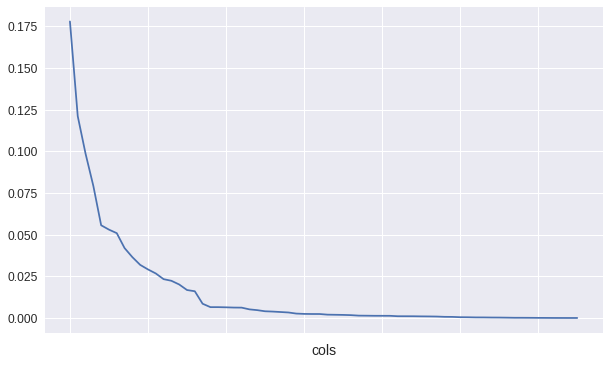

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

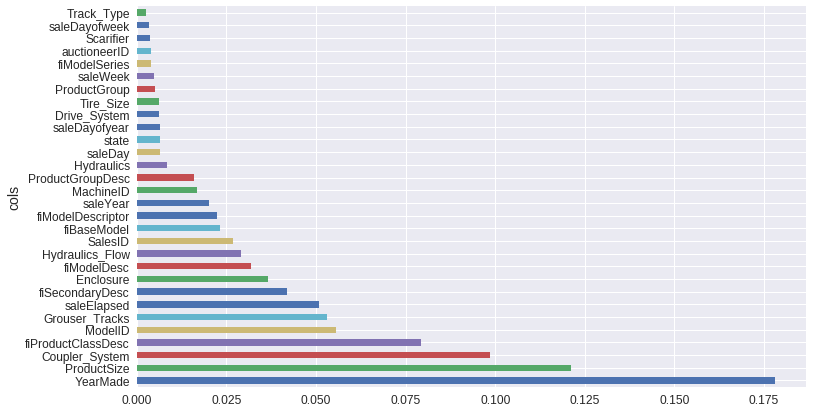

In [0]:
plot_fi(fi[:30]);

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2066375734789672, 0.24530294884797316, 0.9107612634780691, 0.8925383481665837, 0.8944293586919179]


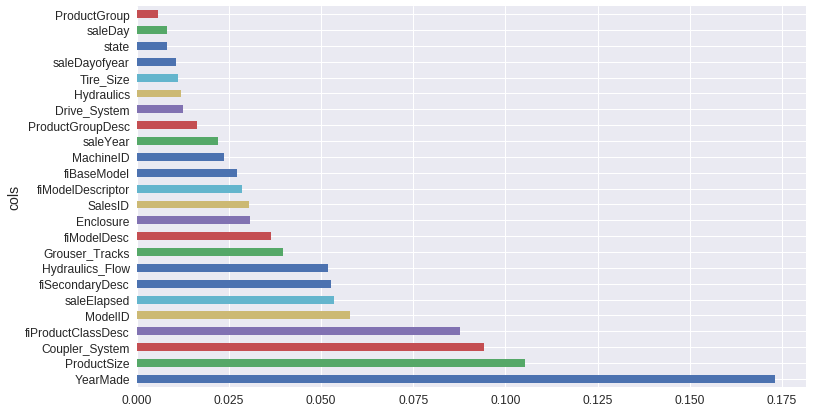

In [0]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20721846423659443, 0.2533617975665706, 0.9102588299784468, 0.8853615679969357, 0.8925938881032469]


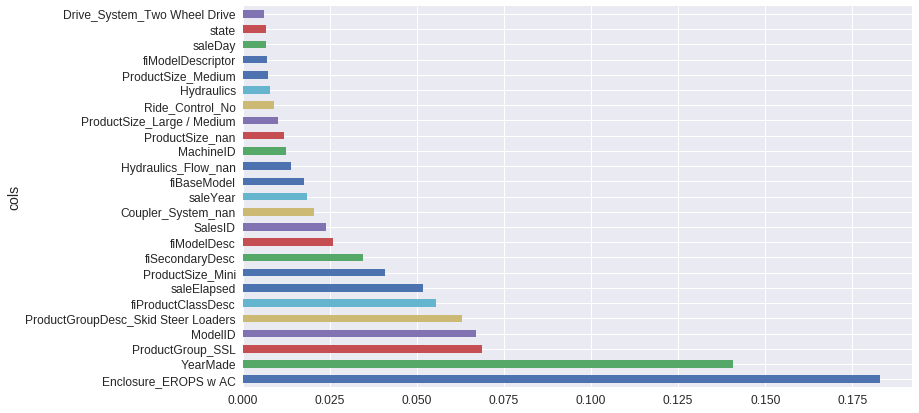

In [0]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

#4 Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [0]:
from scipy.cluster import hierarchy as hc

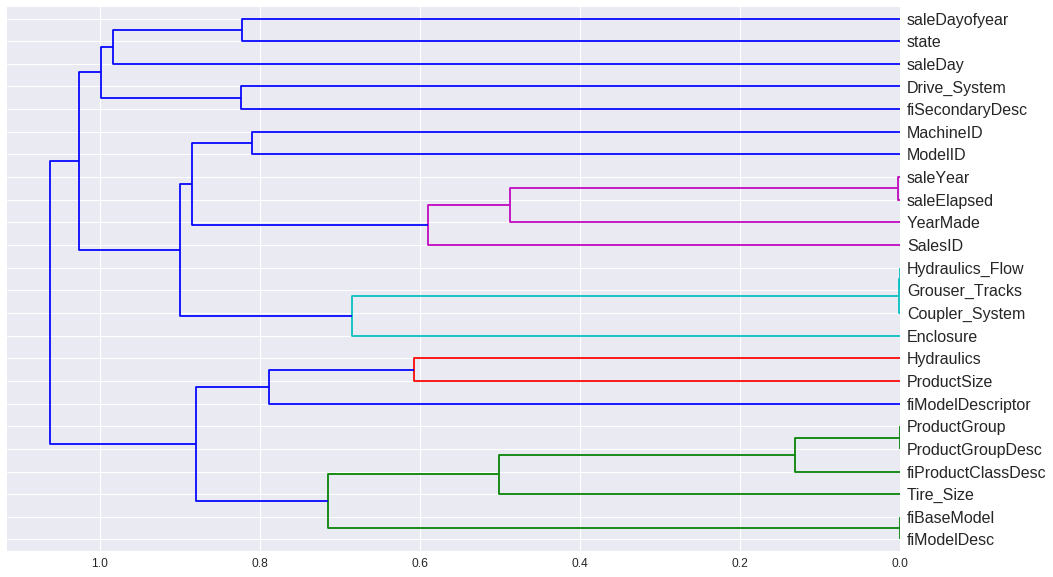

In [0]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [0]:
get_oob(df_keep)

0.8903155196991174

Now we try removing each variable one at a time.

In [0]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8900688679774773
saleElapsed 0.8869859987776446
fiModelDesc 0.8886646313139275
fiBaseModel 0.8896590120875737
Grouser_Tracks 0.8903970503255595
Coupler_System 0.8903283230851944


It looks like we can try one from each group for removal. Let's see what that does.

In [0]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8877940985352832

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [0]:
reset_rf_samples()

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12581785062213796, 0.2280505538321362, 0.9669158981156686, 0.9071225599554886, 0.9085759658357936]


#5 Partial dependence

In [0]:
from pdpbox import pdp
from plotnine import *

In [0]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

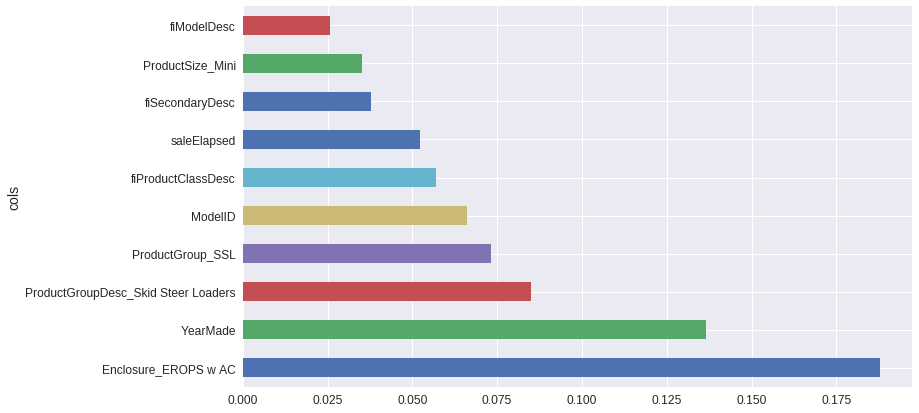

In [0]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


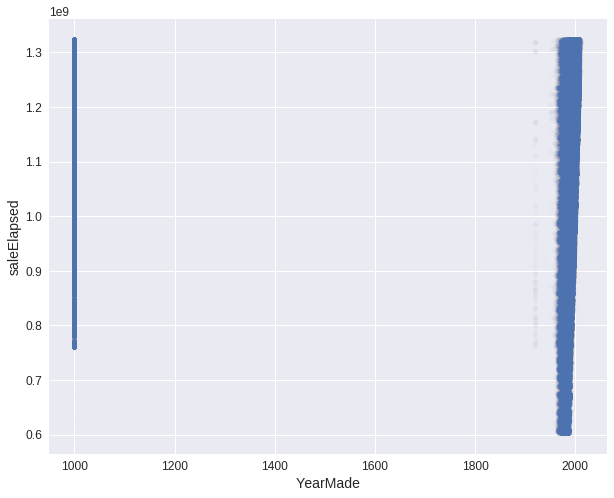

In [0]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

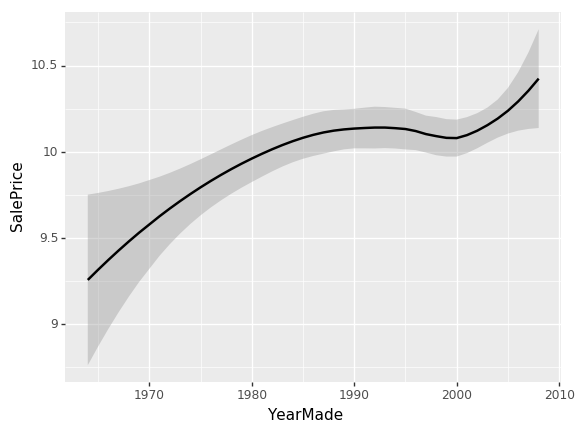

<ggplot: (-9223363297131277038)>

In [0]:
import skmisc
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e0060e7b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e01d44550>})

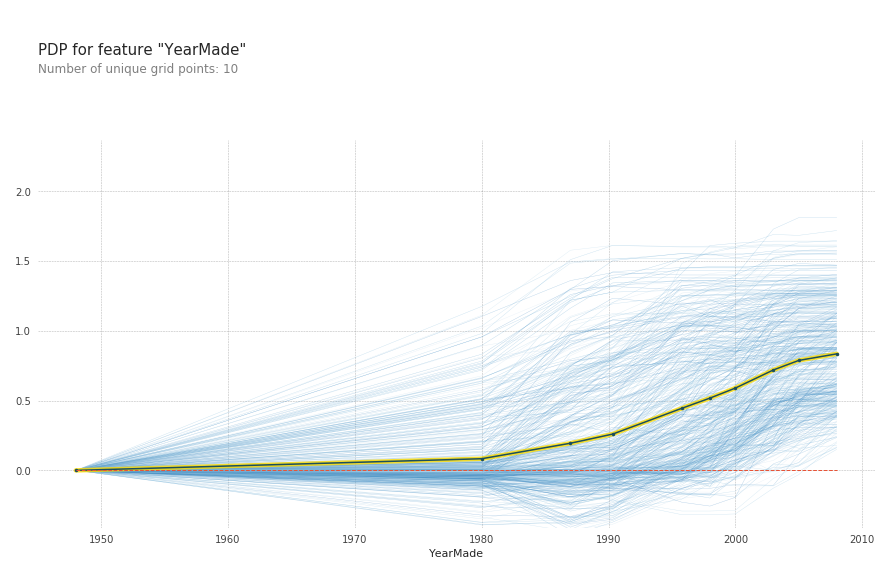

In [0]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e0167fdd8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e01714550>})

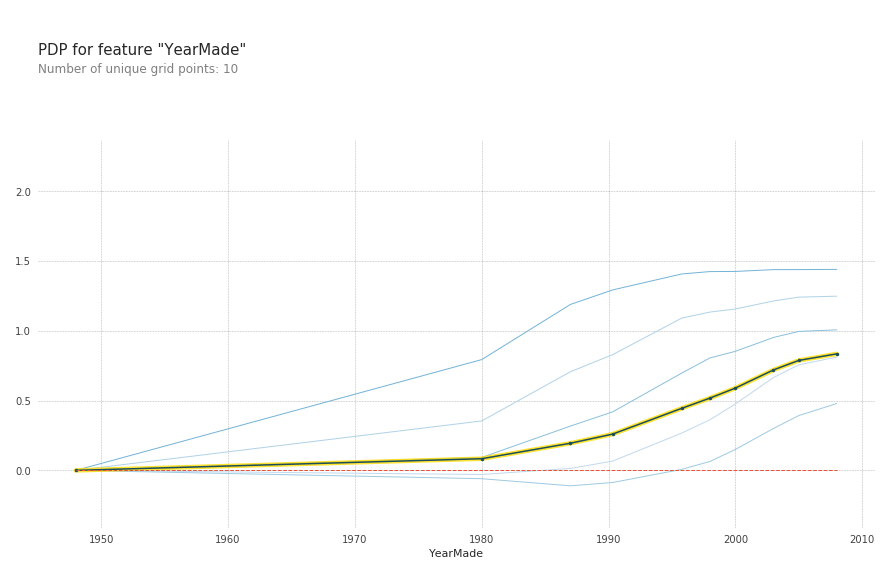

In [0]:
plot_pdp('YearMade', clusters=5)

In [0]:
##  Line added to draw pdp_interact properly
!sed -i '251s/.* /    inter_ax.clabel(c2, /g' /usr/local/lib/python3.6/dist-packages/pdpbox/pdp_plot_utils.py

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e03f1ea58>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e03ee60b8>})

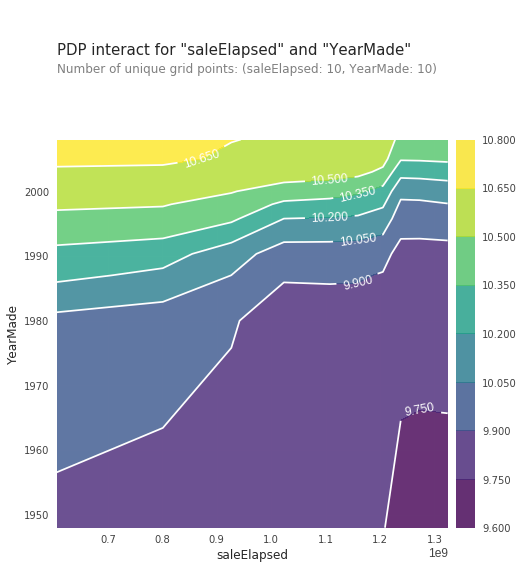

In [0]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e01cb7b38>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2e02d6de80>})

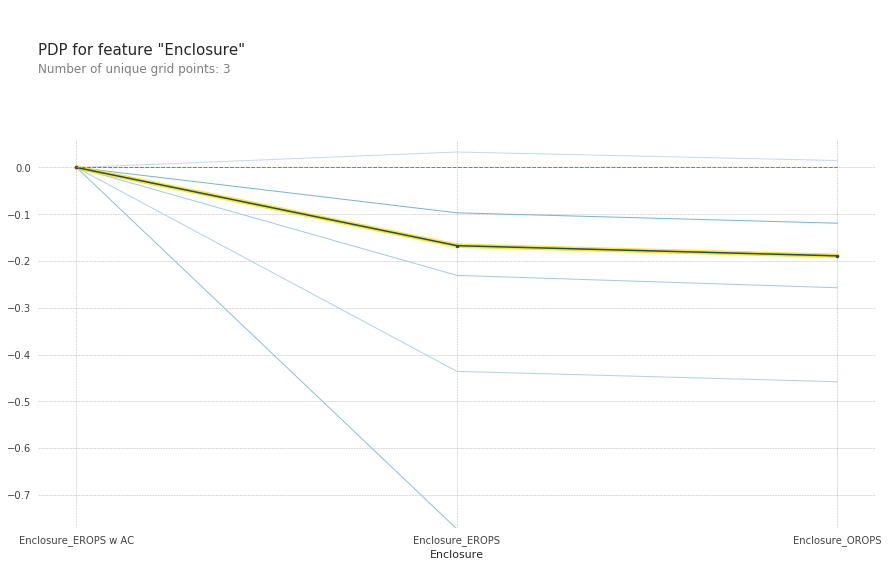

In [0]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

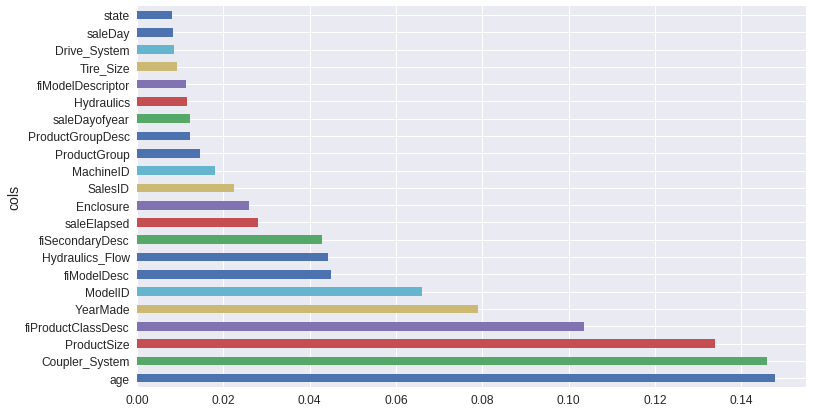

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

#6 Tree interpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [0]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,        665, 1284595200,          0,          1,
              3232,          0,    4364751,          0,    2300944,          4,         12,         16,
                35,        259,          0,          0,          4,         11]])

In [0]:
prediction, bias, contributions = ti.predict(m, row)

In [0]:
prediction[0], bias[0]

(array([9.21494]), 10.106375909227586)

In [0]:
idxs = np.argsort(contributions[0])

In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.6159987133921115),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.18447249957113568),
 ('age', 11, -0.14021295797099528),
 ('fiModelDesc', 'KX1212', -0.06250236311349902),
 ('fiSecondaryDesc', nan, -0.043397733200740696),
 ('MachineID', 2300944, -0.03439302482285318),
 ('fiModelDescriptor', nan, -0.027494786737635522),
 ('saleDayofyear', 259, -0.012447687157935849),
 ('Tire_Size', nan, -0.010332812638567158),
 ('saleDay', 16, -0.00960766991186226),
 ('Enclosure', 'EROPS', -0.0077635152582945285),
 ('state', 'Ohio', -0.003591885739698597),
 ('saleElapsed', 1284595200, 0.003565219114888052),
 ('Drive_System', nan, 0.0037096858612482462),
 ('SalesID', 4364751, 0.004452317194360811),
 ('ProductGroupDesc', 'Track Excavators', 0.0086108512344373),
 ('Hydraulics', 'Standard', 0.01841121172862148),
 ('ProductGroup', 'TEX', 0.019212590371445425),
 ('Hydraulics_Flow', nan, 0.020787643993152784),
 ('ModelID', 665, 0.03259552465554

In [0]:
contributions[0].sum()

-0.8914348469951269

#7 Extrapolation

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999875350576504

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.821107
5,saleElapsed,0.128331
12,MachineID,0.038982
17,saleDayofyear,0.006196
0,YearMade,0.001320
4,ModelID,0.001237
2,Coupler_System,0.000641
8,fiModelDesc,0.000458
7,Enclosure,0.000400
21,age,0.000340


In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [0]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789791212215644

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.231891
0,YearMade,0.193656
14,saleDayofyear,0.151874
4,ModelID,0.078457
7,fiModelDesc,0.061707
12,saleDay,0.058535
13,state,0.055719
3,fiProductClassDesc,0.030713
5,fiSecondaryDesc,0.026494
6,Enclosure,0.022247


In [0]:
set_rf_samples(50000)

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20793502248334142, 0.24770120575087484, 0.9096371097263561, 0.8904268327516591, 0.8930674327637963]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.21016163011613642, 0.24684645792846432, 0.9076915023234362, 0.8911817409321015, 0.8914026189083017]
saleElapsed
[0.21422324049743552, 0.25441803991190254, 0.9040890936519402, 0.8844037411607444, 0.8869456712805005]
MachineID
[0.20681727289283397, 0.24467076514911232, 0.9106059856050192, 0.8930915250827265, 0.8949713918340478]
age
[0.20939670554221235, 0.2476422037236544, 0.9083622293298556, 0.8904790268376434, 0.8918268255086299]
YearMade
[0.20876911821588362, 0.25131112312240544, 0.9089107052006647, 0.8872097923803646, 0.8924424196652799]
saleDayofyear
[0.2089500775226039, 0.24389069476280725, 0.908752725901452, 0.8937721392265067, 0.8927216340424103]


In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13872985285824016, 0.21910190041789038, 0.9597769797713515, 0.9142685314709202, 0.9089895818049147]


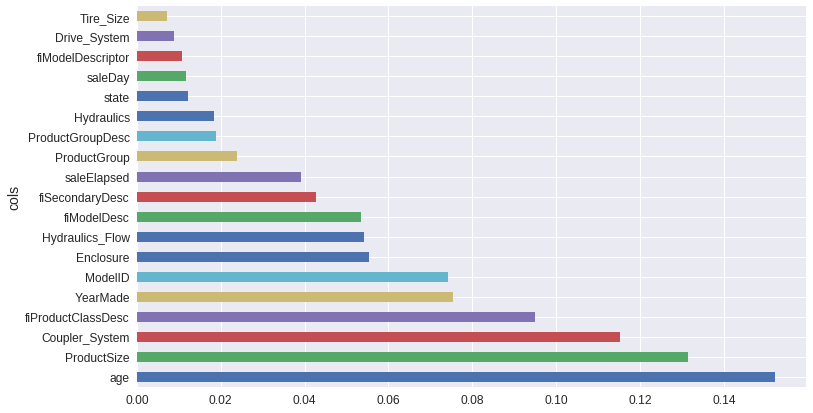

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

#8 Our final model!

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 5s, sys: 2.42 s, total: 5min 8s
Wall time: 2min 41s
[0.08011500292198419, 0.21059333404788028, 0.9865858693536795, 0.9207978055901883, 0.9147414400816866]
